# Applying Bayes Statistics and MCMC method to star distances


## Theory - Bayesian Statistics
What makes Bayes' Thereom useful is that it allows us to use some knowledge or belief that we already have (commonly known as the prior) to help us calculate the probability of a related event.

**Bayes' Theorem**

<figure>
 <img src="images/bayes1.png" alt="From [1]" width="200"/>
</figure>

A term $P(A|B)$, is read as "the probability of A given B".

- The **prior** distribution is the distribution of the parameter(s) before any data is observed. (Theory)
- The sampling distribution is the distribution of the observed data conditional on its parameters. This is also termed the **likelihood**.
- The **posterior** distribution is the distribution of the parameter(s) after taking into account the observed data. This is determined by Bayes' rule, which forms the heart of Bayesian inference. (Experiment)

In other words, Bayes' Theorem can be written as
$$ P(Theory | Data) \propto P(Data | Theory) P(Theory)$$

Why did I completely disregard P(data)?

Sometimes referred to as the evidence. We’re only interested in the parameter values but P(data) doesn’t have any reference to them. In fact, P(data) doesn’t even evaluate to a distribution. It’s just a number. we’ve already observed the data so we can calculate P(data). 

**Intersection probability and Conditional probability**
<figure>
 <img src="images/bayes2.png" alt="From [1]" width="400"/>
</figure>

## Create the data (Prior Distribution)
Let's imagine that we have a population of 10000 stars spread out evenly within the nearest 100 pc. Let's investigate what happens with the probabilities of observing the stars closer or further than they are. 


In [7]:
%matplotlib notebook
import scipy.stats as st
import random
import numpy as np
import matplotlib.pyplot as plt
from BayesMCMC import resources

In [8]:
N_stars = 10000

dist_max = 100.0
# Generate random distances within nearest 100 pc
distance = dist_max*np.random.rand(N_stars)**(1.0/3.0)

# Plot histogram of distances
plt.hist(distance, bins=20, label='Distance Distribution')

# Add plot legend
plt.legend()

# Make plot pretty
plt.gca().set_yticklabels([])

plt.xlabel('Distance (pc)')
plt.ylabel('Probability')

plt.show()

<IPython.core.display.Javascript object>

**Why the distribution rises as $r^2$?**

The volume of an infinitely thin shell is $r^2$ dr. As r increases, the volume scales with $r^2$

## Lutz–Kelker bias 
### Adding measurement uncertainties to our observations (Posterior Distribution)

Practically, this amounts to just adding to the actual distance a random number drawn from a Gaussian distribution centered on zero, with a standard deviation of 20 pc. We show the results below.

In [9]:
%matplotlib inline

bins = np.linspace(0, 125, 20)

# Generate mock observations
dist_err = 20 * np.ones(len(distance))
observed_distance = distance + np.random.normal(scale=dist_err, size=N_stars)

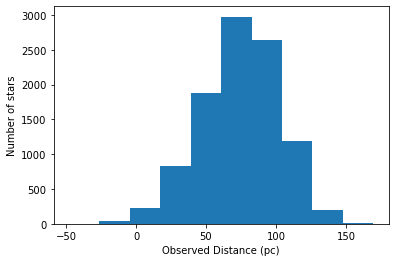

In [10]:
plt.figure()
plt.hist(observed_distance)
plt.xlabel("Observed Distance (pc)")
plt.ylabel("Number of stars")
plt.show()

The most obvious difference here is that some distances appear significantly larger than they actually are. But there's a second, more insidious difference between the two distributions. 

Let's just focus on stars with _apparent_ distances between 70 and 80 pc. Within this distance, I want to compare the number of stars that have apparent distances smaller than their true distances with the number that have larger apparent distances.

In [11]:
# We start by finding the indices of the array values within 5 pc of 75 pc
idx = np.where(np.abs(observed_distance-75.0) < 5.0)[0]

num_lower = len(np.where(observed_distance[idx] < distance[idx])[0])
num_higher = len(np.where(observed_distance[idx] > distance[idx])[0])

print(num_lower, "stars are further than they appear.")
print(num_higher, "stars are closer than they appear.")

946 stars are further than they appear.
550 stars are closer than they appear.


We see that most stars have actual distances larger than the apparent distance, by a large majority. This is very strange. Why is it that when I previously measured my star 10000 times I found that half the time it appeared closer than its true distance, while when I measure 10000 separate stars only about a third of the time does the star appear closer than its true distance?

You can rerun the above blocks several times to convince yourself that this is not just stochastic, random noise. Rather, this is a bias: the actual distance is systematically larger than the observed distance. This bias is called the Lutz-Kelker bias, after the two authors of the paper that first described this bias (https://ui.adsabs.harvard.edu/abs/1973PASP...85..573L/abstract).

**Origin of this bias?**

This bias arises from the fact that we have placed stars in the nearby volume with a constant density. Consider one bin in a histogram of stellar distances. Because of the $r^2$ scaling of stars with distance, there are more stars in the adjacent bin with a slightly larger distance than in the bin with the smaller distance. More stars will "scatter" from larger distances to smaller distances than the opposite, simply because more stars exist at larger distances.

### **Dealing with the Lutz-Kelker bias** (Measurement Using Stellar Parallax)


##### Parallaxes

Astronomers use an effect called parallax to measure distances to nearby stars. Parallax is the apparent displacement of an object because of a change in the observer's point of view. It is perhaps the most accurate method of measuring the distances to stars.
It is essentially model dependent, relying on geometry only. By observing the same star at different times of the year, one can determine the star's distance from how much it moves on the sky. 

<figure>
 <img src="images/parallax.png" alt="From [1]" width="600"/>
</figure>

It's easy to convert distances ($r$) to parallaxes ($p$):

$$ p = \frac{1}{r} $$

NOTE that 1 arcsecond corresponds to 1 pc.

Rather than measure the distance, astrometric observations seek to measure the parallax. So, our uncertainty will be measured as an angle, rather than a distance.

#### $\alpha$ parameter

We start with our probability notation. We want to determine $P(\alpha | \{ p \})$, where the brackets indicate a set of parallax observations. We use our **Bayesian formalism** to split this into a prior and a likelihood:

$$ P(\alpha | \{ p \}) = \frac{1}{\mathcal{Z}} P(\{ p \} | \alpha) P(\alpha). $$


##### What should the prior look like?

In this case the prior will have a minimal effect, but we would like to constrain it to positive values though. Our prior will be:
$$ P(\alpha) = \cases{0 : \alpha <= 0 \\ 1 : \alpha > 0} $$

NOTE: This prior is technically unnormalized and is therefore called an "improper prior." We could fix this by additionally setting a maximum value for $\alpha$ and setting the prior to $1/\alpha_{\rm max}$ for $0 < \alpha < \alpha_{\rm max}$.

##### What about the likelihood?

The overal likelihood is the product of the likelihood of each data point, and the likelihood of each data point is the *normalized* probability density function evaluated at each data point:

$$ P(\{ p \} | \alpha) = \prod_i P(p_i | \alpha) $$
where
$$ P(p_i | \alpha) $$ is the likelihood of the $i$th observation.

##### Likelihood of an observed value

The likelihood of a true underlying distance, $r_{\rm true}$ is

$$ P(r_{\rm true} | \alpha) = (\alpha+1) \frac{r_{\rm true}^{\alpha}}{r_{\rm max}^{\alpha + 1}} $$

We take our likelihood for an individual observation and marginalize over the underlying distance, $r_{\rm true}$:

$$ P( p | \alpha) = \int_{-\infty}^{\infty}  P(r_{\rm true}, p | \alpha)\ dr_{\rm true} $$

We can separate the integral into two, and limit the limits of integration over the allowed range:

$$ P( p | \alpha) = \int_{0}^{r_{\rm max}}  P(p | r_{\rm true})\  P(r_{\rm true} | \alpha)\ dr_{\rm true}$$

Remember that the power law is the distribution in $r_{\rm true}$ not $p_{\rm obs}$ or $r_{\rm obs}$.


##### Converting to the log of the posterior

For numerical simplicity, we use the (natural) log of the posterior, and therefore the log of the prior and the likelihood:

$$ \log P(\alpha | \{ p \}) = \log P(\alpha) + \log P(\{ p \} | \alpha) $$

## Theory - MCMC: Metropolis-Hasting algorithm

### Monte Carlo
A Monte Carlo method is a technique that uses random numbers and probability to solve complex problems. The Monte Carlo simulation, or probability simulation, is a technique used to understand the impact of risk and uncertainty in financial sectors, project management, costs etc. However, it is also used to give solution to many problems in physics (Quantum Physics, Nanotechnology, Astrophysics....).

### Marcov Chain
A Markov Chain is a process where the next state depends only on the current state (a "state" refers to the assignment of values to the parameters). A Markov Chain is memoryless because only the current state matters and not how it arrived in that state. The concept of a Markov Chain is that we do not need to know the entire history of a process to predict the next output, an approximation that works well in many real-world situations.

It is based on the idea of creating a chain of points of the parameter space, using a combination of (i) random walk and (ii) selection of points based on their relative probability.

An algorithm is used to ensure that the chain will reach **equilibrium**: after a number of steps (or legnth of the Markov chain) the chain will contain points that follow the same distribution, the **target distribution**.

#### Metropolis-Hastings algorithm for the distance

Here are the steps:

1. We start with one set of parameters $\theta_1$. 

    - In our case, $\theta_1$ is simply $\alpha$ (angular precision) since we have only one parameter in our model.
    
    - In general, $\theta_1$ can be a vector of 1, 5, or even a million separate parameters.
    
    This first value starts our Markov chain.
      
2. Using some method we obtain a new trial set of parameters $\theta_2$. *A proposition for a new position...*
    
    - It is important that this set is chosen randomly, but based on the previous set.
    - The dependence on only the previous set, is an essential property of a *Markov chain*.
    - The randomness is where the *Monte Carlo* in MCMC comes from.
    - The simplest method to obtain our new parameter values will be to add some random (Gaussian) noise to our current value: $\theta_2 = \theta_1 + \epsilon$. This is also called **step size**.
    
3. Now, we want to calculate and compare the posterior probabilities for both $\theta_1$ and $\theta_2$. If the new parameter is better than the current one,

    $$ P(\theta_2) > P(\theta_1) $$
    we always move the chain to $\theta_2$. If not, we *might* move to $\theta_2$ with probability equal to the ratio
    $$ \frac{P(\theta_2)}{P(\theta_1)}$$
    In practice, we draw a random number from a uniform distribution between 0 and 1. If that random number is less than the ratio, we move the chain to $\theta_2$. Else, we stay at $\theta_1$ for another iteration.

4. Now that we have our new value for $\theta$, we return to step 2 and repeat for as many iterations as we want. Often this is in the thousands or more.

<figure>
 <img src="images/mh.png" alt="From [1]" width="600"/>
 <figcaption>
 <center>Metropolis-Hastings algorithm creating a Markov Chain. From [2].</center>
 </figcaption>
</figure>

## Code 

#### Generate new data (smaller sample)

We will generate 500 stars, evenly distributed within the nearest 100 pc. Then we will observe them with a parallax precision of 2 mas ($10^3$ mas = 1 arcsec).

In [12]:
N_stars = 500

dist_max = 100.0
# Generate random distances within nearest 1000 pc
dist = dist_max*np.random.rand(N_stars)**(1.0/3.0)

plx = 1.0/dist

# Generate mock observations
plx_err = 2.0*1.0e-3 * np.ones(len(plx))
plx_obs = plx + np.random.normal(0.0, plx_err, size=N_stars)


#### Let's run the algorithm for a specific initial value and step size

In [19]:
alpha_0 = 2.6
step_size = 0.3

chain = resources.metro_hastings(resources.ln_posterior, alpha_0, args=(dist_max, plx_obs, plx_err),step_size=step_size, N_steps=200)

2.600,., 2.272,., 2.428,2.345,., 1.942,2.224,2.031,2.271,1.865,1.946,1.957,., ., 2.011,., ., ., ., 1.915,2.196,2.232,., 1.969,2.164,2.153,., ., ., 2.025,1.968,2.197,1.859,., 2.013,2.126,., 2.191,2.082,1.969,2.157,1.871,1.925,., 1.964,2.091,., 2.274,1.937,2.034,2.058,2.382,2.397,., 2.360,2.274,., 1.960,., 1.918,., 2.039,2.074,1.886,., ., ., 1.909,., 2.237,., 2.244,., ., 2.213,., 2.259,., ., 2.281,2.204,., ., ., ., ., ., 2.018,., ., ., ., ., ., ., ., 1.778,1.691,1.804,2.025,2.323,2.068,., 2.028,., ., 2.043,1.835,1.887,1.891,., 2.049,2.012,2.098,2.106,., 2.228,., 2.174,., ., ., 2.158,2.162,2.336,2.120,2.156,., ., ., 1.949,1.821,1.829,., 2.013,., 1.991,., 2.186,., ., ., ., 2.147,., ., ., 1.958,., 1.897,1.877,2.100,., 2.064,., 2.177,., 2.133,., 1.982,., ., 2.159,., ., 1.814,., 1.759,., ., ., 1.721,., 1.896,1.933,1.868,., ., 1.834,., 1.873,1.941,2.012,2.020,., 1.963,., 2.013,., 2.283,., ., 1.960,., 2.000,., 2.017,1.815,

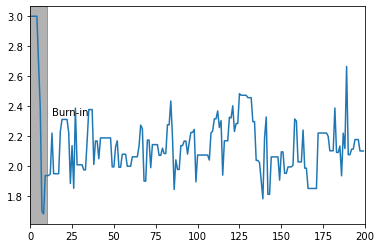

In [16]:
n_burnin = 10   # change this value if needed

plt.figure()
plt.axvspan(0, n_burnin, color="k", alpha=0.3)
plt.plot(chain)
_, _, y_min, y_max = plt.axis()
plt.text(n_burnin + 3, (y_min + y_max) / 2.0, "Burn-in")
chain_converged = chain[n_burnin:]
plt.xlim(0,len(chain))
plt.show()

#### Our results: using confidence intervals

Now, we can plot the posterior distribution of $\alpha$ to obtain our final result.

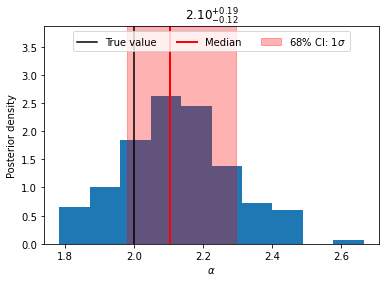

In [18]:
plt.figure()
plt.hist(chain_converged, bins=10, density=True)
_, _, _, y_max = plt.axis()
plt.ylim(ymax=y_max*1.4)

lo68, median, hi68 = np.percentile(chain_converged, [16,50,84])

plt.axvline(2.0, color="k", label="True value")
plt.axvline(median, color="r", linewidth=2, label="Median")
plt.axvspan(lo68, hi68, color="r", alpha=0.3, label="68% CI: 1$\sigma$")
plt.title(r"${:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$".format(median, hi68 - median, median - lo68))
plt.xlabel(r"$\alpha$")
plt.ylabel("Posterior density")
plt.legend(loc="upper center", ncol=3)
plt.show()

## References

1. Wikipedia contributors. (2019, May 9). Test functions for optimization. In Wikipedia, The Free Encyclopedia. Retrieved 20:20, June 12, 2019, from https://en.wikipedia.org/w/index.php?title=Test_functions_for_optimization&oldid=896257708

2. Lee, Jaewook & Sung, Woosuk & Choi, Joo-Ho. (2015). Metamodel for Efficient Estimation of Capacity-Fade Uncertainty in Li-Ion Batteries for Electric Vehicles. Energies. 8. 5538-5554. 10.3390/en8065538.

3. Foreman-Mackey, D., Hogg, D. W., Lang, D., & Goodman, J. 2013, PASP, 125, 306

4. Adrian Price-Whelan : https://adrian.pw/blog/fitting-a-line/

5. Estimate distances from parallaxes : https://iopscience.iop.org/article/10.3847/0004-637X/832/2/137/pdf

6. http://khartoumspace.uofk.edu/bitstream/handle/123456789/5578/Monte%20Carlo%20Simulations%20Simulating%20Radioactivity.pdf?sequence=1&isAllowed=y